#Αναγνώριση Προτύπων - Μηχανική Μάθηση - Εργασία 3
## Νικόλαος Μασούρας sdi1800112

In [2]:
import numpy as np
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler  as lr
from sklearn.metrics import f1_score, accuracy_score
import time
import matplotlib.pyplot as plt
import numpy as np


data_location = r'/content/gdrive/MyDrive/ML/EX_3/music_genre_data_di'

Δημιουργία dictionary για map απο είδος μουσικής σε ακέραιο και συνάρτησης που δέχεται ένα np array από είδη μουσικής και επιστρέφει πίνακα με ακεραίους.

In [4]:
music_genres = {
    'blues': 0,
    'classical': 1,
    'hiphop': 2,
    'rock_metal_hardrock': 3
}


def genresToNum(arr):
  arr = np.where(arr == 'blues', music_genres['blues'],arr)
  arr = np.where(arr == 'classical', music_genres['classical'],arr)
  arr = np.where(arr == 'hiphop', music_genres['hiphop'],arr)
  arr = np.where(arr == 'rock_metal_hardrock', music_genres['rock_metal_hardrock'],arr)
  return arr.astype('int64')

##Ερώτημα 1: Feedforward Neural Network

###Βήμα 1: Φόρτωση δεδομένων (mfccs)

Φόρτωση δεδομένων σε πίνακες.

In [16]:
X_test_Mfccs = np.load(data_location + '/test/mfccs/X.npy')
Y_test_Mfccs = np.load(data_location + '/test/mfccs/labels.npy')

X_train_Mfccs = np.load(data_location + '/train/mfccs/X.npy')
Y_train_Mfccs = np.load(data_location + '/train/mfccs/labels.npy')

X_val_Mfccs = np.load(data_location + '/val/mfccs/X.npy')
Y_val_Mfccs = np.load(data_location + '/val/mfccs/labels.npy')

In [17]:
print(np.unique(Y_train_Mfccs))

['blues' 'classical' 'hiphop' 'rock_metal_hardrock']


Map ειδών μουσικής σε ακεραίους.

In [18]:
Y_test_Mfccs = genresToNum(Y_test_Mfccs)
Y_train_Mfccs = genresToNum(Y_train_Mfccs)
Y_val_Mfccs = genresToNum(Y_val_Mfccs)

Δημιουργία dataloaders χρησιμοποιώντας tensor datasets. 

In [19]:
X_train_Mfccs = torch.from_numpy(X_train_Mfccs).type(torch.float)
Y_train_Mfccs = torch.from_numpy(Y_train_Mfccs)

X_test_Mfccs = torch.from_numpy(X_test_Mfccs).type(torch.float)
Y_test_Mfccs = torch.from_numpy(Y_test_Mfccs)

X_val_Mfccs = torch.from_numpy(X_val_Mfccs).type(torch.float)
Y_val_Mfccs = torch.from_numpy(Y_val_Mfccs)


In [20]:

train_dataset = TensorDataset(X_train_Mfccs,Y_train_Mfccs)
train_dataloader = DataLoader(train_dataset,batch_size=16, shuffle=True)

test_dataset = TensorDataset(X_test_Mfccs,Y_test_Mfccs)
test_dataloader = DataLoader(test_dataset,batch_size=16)

val_dataset = TensorDataset(X_val_Mfccs,Y_val_Mfccs)
val_dataloader = DataLoader(val_dataset,batch_size=16, shuffle=True)

###Βήμα 2: Ορισμός Νευρωνικού Δικτύου

In [21]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(26, 128)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, 4)

  def forward(self,x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x


In [27]:
model = Net()
print(model) 

Net(
  (fc1): Linear(in_features=26, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


###Βήμα 3: Ορισμός διαδικασίας εκπαίδευσης

In [22]:
def trainMfccs(epochs,optimizer,loader,lossFunction,model):
  model.train()
  for epoch in range(epochs):
    for i, data in enumerate(loader):
      
      x, y = data
      optimizer.zero_grad()

      outputs = model(x)

      loss = lossFunction(outputs,y)
      
      loss.backward()
      optimizer.step()

      if(i % 50 == 0):
        print(f"Epoch: {epoch}  | Batch: {i}  | Train Loss: {loss.item()}")
  return model


###Βήμα 4: Ορισμός διαδικασίας αξιολόγησης

In [23]:
def testMfccs(loader,model,lossFunction):
  preds = torch.tensor([])
  true = torch.tensor([]).type(torch.LongTensor)
  confusion_matrix = torch.zeros(4,4,dtype=torch.int32)
  model.eval()
  with torch.no_grad():
    for x, y in loader:
      
      outputs = model(x)
      preds = torch.cat((preds,outputs),dim=0)
      true = torch.cat((true,y),dim=0)

  loss = lossFunction(preds,true)
  
  stack = torch.stack((true,preds.argmax(dim=1)),dim=1)
  #build confusion matrix
  for pred in stack:
    actual,predicted = pred.tolist()
    confusion_matrix[actual,predicted] = confusion_matrix[actual,predicted] + 1

  predicted = preds.argmax(dim=1).numpy()
  actual = true.numpy()
  f1 = f1_score(actual,predicted,average='macro')
  accuracy = accuracy_score(actual,predicted)
  return loss, f1, accuracy, confusion_matrix


      

###Βήμα 5: Εκπαίδευση δικτύου

In [28]:

optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()

start = time.time()

trained_model = trainMfccs(30,optimizer,train_dataloader,lossFunction,model)

stop = time.time()

print('Time: ', stop - start)

loss, f1, accuracy, confusion_matrix = testMfccs(test_dataloader,trained_model,lossFunction)



Epoch: 0  | Batch: 0  | Train Loss: 1.715323805809021
Epoch: 0  | Batch: 50  | Train Loss: 1.390752911567688
Epoch: 0  | Batch: 100  | Train Loss: 1.3972828388214111
Epoch: 0  | Batch: 150  | Train Loss: 1.4097850322723389
Epoch: 1  | Batch: 0  | Train Loss: 1.3862513303756714
Epoch: 1  | Batch: 50  | Train Loss: 1.3865385055541992
Epoch: 1  | Batch: 100  | Train Loss: 1.34849214553833
Epoch: 1  | Batch: 150  | Train Loss: 1.3142402172088623
Epoch: 2  | Batch: 0  | Train Loss: 1.3801159858703613
Epoch: 2  | Batch: 50  | Train Loss: 1.4715099334716797
Epoch: 2  | Batch: 100  | Train Loss: 1.320965051651001
Epoch: 2  | Batch: 150  | Train Loss: 1.354346752166748
Epoch: 3  | Batch: 0  | Train Loss: 1.3376438617706299
Epoch: 3  | Batch: 50  | Train Loss: 1.3603788614273071
Epoch: 3  | Batch: 100  | Train Loss: 1.4449278116226196
Epoch: 3  | Batch: 150  | Train Loss: 1.3238003253936768
Epoch: 4  | Batch: 0  | Train Loss: 1.3065860271453857
Epoch: 4  | Batch: 50  | Train Loss: 1.274138689041

In [29]:
print(f'Total loss is {loss.item()}')
print(f'F1 score is {f1}')
print(f'Accuracy score is {accuracy}')

Total loss is 0.9279499650001526
F1 score is 0.6143648779843809
Accuracy score is 0.6380813953488372


In [30]:
print(confusion_matrix)

tensor([[ 73,  25,  85, 141],
        [ 29, 235,  10,  23],
        [ 42,  13, 268,  33],
        [ 27,  29,  41, 302]], dtype=torch.int32)


Παρατηρούμε ότι οι προβλέψεις είναι αρκετά ανακριβής.Επίσης το δίκτυο φαίνεται να έχει αρκετά κακή απόδοση στην πρόβλεψη μουσικής μπλουζ.

###Βήμα 6: Εκπαίδευση δικτύου με GPU

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Αρχικοποίηση νευρωνικού στη gpu και δημιουργία train dataloader με δεδομένα στη gpu.

In [32]:
model_gpu = Net().to(device)
x_train_gpu = X_train_Mfccs.to(device)
y_train_gpu = Y_train_Mfccs.to(device)
train_dataset_gpu = TensorDataset(x_train_gpu,y_train_gpu)
train_dataloader_gpu = DataLoader(train_dataset_gpu,batch_size=16, shuffle=True)


In [33]:

optimizer = torch.optim.SGD(model_gpu.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()


start = time.time()

trained_model = trainMfccs(30,optimizer,train_dataloader_gpu,lossFunction,model_gpu)

stop = time.time()

print('Time: ', stop - start)

loss, f1, accuracy, confusion_matrix = testMfccs(test_dataloader,trained_model.cpu(),lossFunction)




Epoch: 0  | Batch: 0  | Train Loss: 1.5460115671157837
Epoch: 0  | Batch: 50  | Train Loss: 1.3923512697219849
Epoch: 0  | Batch: 100  | Train Loss: 1.3882496356964111
Epoch: 0  | Batch: 150  | Train Loss: 1.3476279973983765
Epoch: 1  | Batch: 0  | Train Loss: 1.345931053161621
Epoch: 1  | Batch: 50  | Train Loss: 1.3170109987258911
Epoch: 1  | Batch: 100  | Train Loss: 1.452770709991455
Epoch: 1  | Batch: 150  | Train Loss: 1.3368618488311768
Epoch: 2  | Batch: 0  | Train Loss: 1.3388952016830444
Epoch: 2  | Batch: 50  | Train Loss: 1.3378791809082031
Epoch: 2  | Batch: 100  | Train Loss: 1.337365746498108
Epoch: 2  | Batch: 150  | Train Loss: 1.3988255262374878
Epoch: 3  | Batch: 0  | Train Loss: 1.2731366157531738
Epoch: 3  | Batch: 50  | Train Loss: 1.329689621925354
Epoch: 3  | Batch: 100  | Train Loss: 1.340013027191162
Epoch: 3  | Batch: 150  | Train Loss: 1.2474424839019775
Epoch: 4  | Batch: 0  | Train Loss: 1.2490335702896118
Epoch: 4  | Batch: 50  | Train Loss: 1.31444609165

Παρατηρούμε ότι παρά το γεγονός οτι το δίκτυο εκπαιδεύτηκε χρησιμοποιώντας τη gpu ο χρόνος εκπαίδευσης αυξήθηκε. 

In [34]:
print(f'Total loss is {loss.item()}')
print(f'F1 score is {f1}')
print(f'Accuracy score is {accuracy}')

Total loss is 0.9499813318252563
F1 score is 0.591357015319206
Accuracy score is 0.6257267441860465


In [35]:
print(confusion_matrix)

tensor([[ 53,  26, 127, 118],
        [ 24, 234,  19,  20],
        [ 30,  13, 289,  24],
        [ 24,  31,  59, 285]], dtype=torch.int32)


###Βήμα 7: Επιλογή μοντέλου

In [36]:
model = Net()

Στη παρακάτω διαδικασία εκπαίδευσης στο τέλος κάθε εποχής συγκρίνουμε το f1 score του validation set με το καλύτερο f1 score μέχρι εκείνη τη στιγμή και αποθηκεύουμε το μοντέλο αν πετυχαίνει καλύτερο f1.Το μοντέλο που τελικά επιστρέφεται θα είναι αυτό που πετυχαίνει καλύτερο f1 στο validation set.

In [37]:
def trainMfccsWithVal(epochs,optimizer,loader,lossFunction,model,val_loader):
  temp_f1 = 0
  for epoch in range(epochs):
    for i, data in enumerate(loader):
      model.train()
      x, y = data
      
      optimizer.zero_grad()

      outputs = model(x)

      loss = lossFunction(outputs,y)

      
      loss.backward()
      optimizer.step()

    loss, f1, accuracy, confusion_matrix = testMfccs(val_loader,model,lossFunction)

    if f1 > temp_f1:
      temp_model = model
      temp_f1 = f1
  return temp_model

In [38]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()


trained_model = trainMfccsWithVal(30,optimizer,train_dataloader,lossFunction,model,val_dataloader)

loss, f1, accuracy, confusion_matrix = testMfccs(test_dataloader,trained_model,lossFunction)

In [39]:
print(f'Total loss is {loss.item()}')
print(f'F1 score is {f1}')
print(f'Accuracy score is {accuracy}')

Total loss is 0.9766839742660522
F1 score is 0.5718584190522313
Accuracy score is 0.6184593023255814


In [40]:
print(confusion_matrix)

tensor([[ 34,  24, 131, 135],
        [ 22, 224,  25,  26],
        [ 14,  13, 291,  38],
        [ 22,  21,  54, 302]], dtype=torch.int32)


Παρατηρούμε ότι παρά τη χρήση validation κατά τη διαδικασία εκπαίδευσης η απόδοση του μοντέλου δε βελτιώθηκε. 

##Ερώτημα 2: Convolutional Neural Network

###Βήμα 1: Φόρτωση δεδομένων (spectrograms)

Αντίστοιχη διαδικασία με τα MFCCs δεδομένα

In [41]:
X_test_melgrams = np.load(data_location + '/test/melgrams/X.npy')
Y_test_melgrams = np.load(data_location + '/test/melgrams/labels.npy')

X_train_melgrams = np.load(data_location + '/train/melgrams/X.npy')
Y_train_melgrams = np.load(data_location + '/train/melgrams/labels.npy')

X_val_melgrams = np.load(data_location + '/val/melgrams/X.npy')
Y_val_melgrams = np.load(data_location + '/val/melgrams/labels.npy')

In [42]:
Y_test_melgrams = genresToNum(Y_test_melgrams)
Y_train_melgrams = genresToNum(Y_train_melgrams)
Y_val_melgrams = genresToNum(Y_val_melgrams)

In [43]:
x_train_melgrams = torch.from_numpy(X_train_melgrams).type(torch.float)
y_train_melgrams = torch.from_numpy(Y_train_melgrams)

x_test_melgrams = torch.from_numpy(X_test_melgrams).type(torch.float)
y_test_melgrams = torch.from_numpy(Y_test_melgrams)

x_val_melgrams = torch.from_numpy(X_val_melgrams).type(torch.float)
y_val_melgrams = torch.from_numpy(Y_val_melgrams)


In [44]:
train_dataset_melgrams = TensorDataset(x_train_melgrams,y_train_melgrams)
train_dataloader_melgrams = DataLoader(train_dataset_melgrams,batch_size=16, shuffle=True)

test_dataset_melgrams = TensorDataset(x_test_melgrams,y_test_melgrams)
test_dataloader_melgrams = DataLoader(test_dataset_melgrams,batch_size=16)

val_dataset_melgrams = TensorDataset(x_val_melgrams,y_val_melgrams)
val_dataloader_melgrams = DataLoader(val_dataset_melgrams,batch_size=16, shuffle=True)

**Visulization**

In [45]:
import librosa
import librosa.display


Οπτικοποίηση mel spectogram μπλουζ μουσικής.


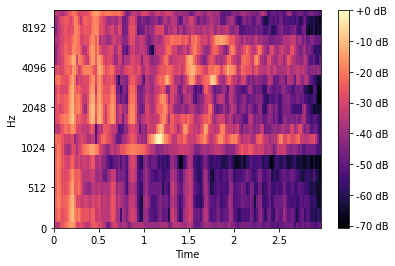

In [46]:
librosa.display.specshow(X_test_melgrams[1],x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

Οπτικοποίηση mel spectogram κλασσικής μουσικής.


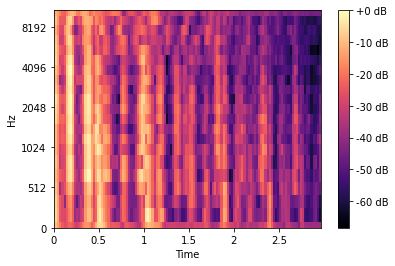

In [47]:
librosa.display.specshow(X_test_melgrams[500],x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

Οπτικοποίηση mel spectogram ροκ μουσικής.


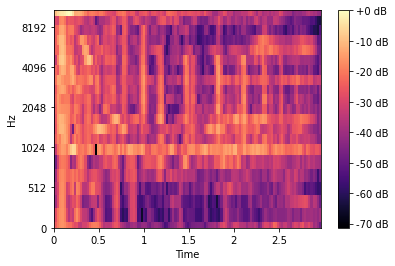

In [48]:
librosa.display.specshow(X_test_melgrams[800],x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

Οπτικοποίηση mel spectogram χιπ χοπ μουσικής.


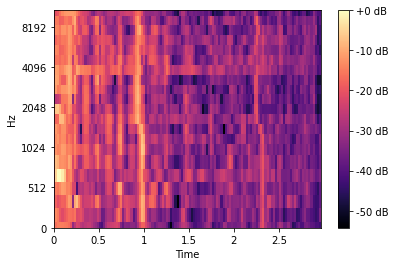

In [49]:
librosa.display.specshow(X_test_melgrams[1300],x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

###Βήμα 2: Ορισμός Νευρωνικού Δικτύου

In [52]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.conv3 = nn.Conv2d(32, 64, 5)
    self.conv4 = nn.Conv2d(64, 128, 5)
    self.fc1 = nn.Linear(71680, 1024)
    self.fc2 = nn.Linear(1024, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, 4)

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)

    x = x.view(x.size(0), -1)

    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)

    return x

In [53]:
model = ConvNet()
print(model) 

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=71680, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=4, bias=True)
)


###Βήμα 3: Εκπαίδευση δικτύου

Ορισμός διαδικασίας εκπαίδευσης η οποία περιέχει validation.

In [54]:
def trainMel(epochs,optimizer,loader,lossFunction,model,val_loader):
  temp_f1 = 0
  
  for epoch in range(epochs):
    for i, data in enumerate(loader):
      model.train()
      x, y = data
      
      x = x.unsqueeze(1)
      
      optimizer.zero_grad()

      outputs = model(x)

      loss = lossFunction(outputs,y)

      
      loss.backward()
      optimizer.step()

      if(i % 50 == 0):
        print(f"Epoch: {epoch}  | Batch: {i}  | Train Loss: {loss.item()}")

    loss, f1, accuracy, confusion_matrix = testMel(val_loader,model,lossFunction)

    if f1 > temp_f1:
      temp_f1 = f1
      temp_model = model
  return temp_model


Ορισμός διαδικασίας αξιολόγισης

In [55]:
def testMel(loader,model,lossFunction):
  preds = torch.tensor([])
  true = torch.tensor([]).type(torch.LongTensor)
  confusion_matrix = torch.zeros(4,4,dtype=torch.int32)
  model.eval()
  with torch.no_grad():
    for x, y in loader:
      
      x = x.unsqueeze(1)
      outputs = model(x)
      preds = torch.cat((preds,outputs),dim=0)
      true = torch.cat((true,y),dim=0)

  loss = lossFunction(preds,true)
  
  stack = torch.stack((true,preds.argmax(dim=1)),dim=1)
  #build confusion matrix
  for pred in stack:
    actual,predicted = pred.tolist()
    confusion_matrix[actual,predicted] = confusion_matrix[actual,predicted] + 1

  predicted = preds.argmax(dim=1).numpy()
  actual = true.numpy()
  f1 = f1_score(actual,predicted,average='macro')
  accuracy = accuracy_score(actual,predicted)
  return loss, f1, accuracy, confusion_matrix


In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()

trained_model = trainMel(30,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams)

loss, f1, accuracy, confusion_matrix = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Epoch: 0  | Batch: 0  | Train Loss: 1.3748530149459839
Epoch: 0  | Batch: 50  | Train Loss: 1.3721022605895996
Epoch: 0  | Batch: 100  | Train Loss: 1.399196743965149
Epoch: 0  | Batch: 150  | Train Loss: 1.3245081901550293
Epoch: 1  | Batch: 0  | Train Loss: 1.2898606061935425
Epoch: 1  | Batch: 50  | Train Loss: 1.3880252838134766
Epoch: 1  | Batch: 100  | Train Loss: 1.3513233661651611
Epoch: 1  | Batch: 150  | Train Loss: 1.3042807579040527
Epoch: 2  | Batch: 0  | Train Loss: 1.3863511085510254
Epoch: 2  | Batch: 50  | Train Loss: 1.2223496437072754
Epoch: 2  | Batch: 100  | Train Loss: 1.1636072397232056
Epoch: 2  | Batch: 150  | Train Loss: 0.9120439887046814
Epoch: 3  | Batch: 0  | Train Loss: 1.1565550565719604
Epoch: 3  | Batch: 50  | Train Loss: 1.432539463043213
Epoch: 3  | Batch: 100  | Train Loss: 1.1173744201660156
Epoch: 3  | Batch: 150  | Train Loss: 1.1608058214187622
Epoch: 4  | Batch: 0  | Train Loss: 1.1730904579162598
Epoch: 4  | Batch: 50  | Train Loss: 1.07500195

In [ ]:
print(f'Total loss is {loss.item()}')
print(f'F1 score is {f1}')
print(f'Accuracy score is {accuracy}')

Total loss is 2.94305419921875
F1 score is 0.6375818983198228
Accuracy score is 0.6344476744186046


In [ ]:
print(confusion_matrix)

tensor([[153,  26,  41, 104],
        [ 38, 227,   7,  25],
        [ 38,  18, 245,  55],
        [ 75,  23,  53, 248]], dtype=torch.int32)


Παρατηρούμε ότι το συγκεκριμένο δίκτυο παίρνει πολύ χρονο για να εκπαιδευτεί(πάνω από 1 ώρα) ενώ δε παράγει αρκετά ικανοποιητικά αποτελέσματα.

###Βήμα 4: Pooling and padding

Ορισμός δικτύου με pooling και padding.

In [56]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    self.conv1 = nn.Conv2d(1, 16, 5,padding=2)
    self.conv2 = nn.Conv2d(16, 32, 5,padding=2)
    self.conv3 = nn.Conv2d(32, 64, 5,padding=2)
    self.conv4 = nn.Conv2d(64, 128, 5,padding=2)
    self.fc1 = nn.Linear(1024, 1024)
    self.fc2 = nn.Linear(1024, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, 4)

  def forward(self,x):
    x = F.max_pool2d(self.conv1(x),kernel_size=2)

    x = F.max_pool2d(self.conv2(x),kernel_size=2)

    x = F.max_pool2d(self.conv3(x),kernel_size=2)

    x = F.max_pool2d(self.conv4(x),kernel_size=2)

    x = x.view(x.size(0), -1)

    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    x = self.fc4(x)

    return x

In [57]:
model = ConvNet()

In [58]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()

trained_model = trainMel(30,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams)

loss, f1, accuracy, confusion_matrix = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Epoch: 0  | Batch: 0  | Train Loss: 1.3711189031600952
Epoch: 0  | Batch: 50  | Train Loss: 1.425708293914795
Epoch: 0  | Batch: 100  | Train Loss: 1.3456138372421265
Epoch: 0  | Batch: 150  | Train Loss: 1.2216953039169312
Epoch: 1  | Batch: 0  | Train Loss: 1.1224749088287354
Epoch: 1  | Batch: 50  | Train Loss: 1.2410383224487305
Epoch: 1  | Batch: 100  | Train Loss: 1.1076281070709229
Epoch: 1  | Batch: 150  | Train Loss: 1.1257120370864868
Epoch: 2  | Batch: 0  | Train Loss: 1.1537259817123413
Epoch: 2  | Batch: 50  | Train Loss: 0.9362295866012573
Epoch: 2  | Batch: 100  | Train Loss: 1.153283715248108
Epoch: 2  | Batch: 150  | Train Loss: 0.9212030172348022
Epoch: 3  | Batch: 0  | Train Loss: 0.855668842792511
Epoch: 3  | Batch: 50  | Train Loss: 1.1336160898208618
Epoch: 3  | Batch: 100  | Train Loss: 1.070232629776001
Epoch: 3  | Batch: 150  | Train Loss: 0.8400083780288696
Epoch: 4  | Batch: 0  | Train Loss: 0.9412916302680969
Epoch: 4  | Batch: 50  | Train Loss: 0.7804263830

In [59]:
print(f'Total loss is {loss.item()}')
print(f'F1 score is {f1}')
print(f'Accuracy score is {accuracy}')

Total loss is 1.3170559406280518
F1 score is 0.7314620090840939
Accuracy score is 0.7238372093023255


In [60]:
print(confusion_matrix)

tensor([[204,   8,  31,  81],
        [ 29, 257,   4,   7],
        [ 39,   3, 282,  32],
        [ 88,  15,  43, 253]], dtype=torch.int32)


Το δίκτυο με pooling βελτιώνει τη ταχύτητα εκπαίδευσης καθώς μειώνονται οι αριθμοί νευρώνων στο πρώτο επίπεδο του πλήρως συνδεδεμένου δίκτυου ενώ βελτιώνεται και η απόδοση σε μικρό βαθμο. 

###Βήμα 5: Αλγόριθμοι βελτιστοποίησης

Παρακάτω εκπαιδεύονται δίκτυα χρησιμοποιώντας διαφορετικούς αλγόριθμους βελτιστοποίησης και παρουσιάζονται τα αποτελέσματα σε πίνακα.

In [61]:
model = ConvNet()

optimizer = torch.optim.SGD(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()

trained_model = trainMel(30,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams)


loss_SGD, f1_SGD, accuracy_SGD, confusion_matrix_SGD = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Epoch: 0  | Batch: 0  | Train Loss: 1.4248591661453247
Epoch: 0  | Batch: 50  | Train Loss: 1.377649188041687
Epoch: 0  | Batch: 100  | Train Loss: 1.2804348468780518
Epoch: 0  | Batch: 150  | Train Loss: 1.350178837776184
Epoch: 1  | Batch: 0  | Train Loss: 1.283706545829773
Epoch: 1  | Batch: 50  | Train Loss: 1.241910696029663
Epoch: 1  | Batch: 100  | Train Loss: 1.1286178827285767
Epoch: 1  | Batch: 150  | Train Loss: 1.1338130235671997
Epoch: 2  | Batch: 0  | Train Loss: 1.2201390266418457
Epoch: 2  | Batch: 50  | Train Loss: 0.9656040668487549
Epoch: 2  | Batch: 100  | Train Loss: 0.9238249063491821
Epoch: 2  | Batch: 150  | Train Loss: 1.174476146697998
Epoch: 3  | Batch: 0  | Train Loss: 1.1698362827301025
Epoch: 3  | Batch: 50  | Train Loss: 1.0621464252471924
Epoch: 3  | Batch: 100  | Train Loss: 0.9670343995094299
Epoch: 3  | Batch: 150  | Train Loss: 0.9023266434669495
Epoch: 4  | Batch: 0  | Train Loss: 0.8744823336601257
Epoch: 4  | Batch: 50  | Train Loss: 0.97969907522

In [62]:
model = ConvNet()

optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()

trained_model = trainMel(30,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams)


loss_adagrad, f1_adagrad, accuracy_adagrad, confusion_matrix_adagrad = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Epoch: 0  | Batch: 0  | Train Loss: 1.4466090202331543
Epoch: 0  | Batch: 50  | Train Loss: 1.4145814180374146
Epoch: 0  | Batch: 100  | Train Loss: 1.1788873672485352
Epoch: 0  | Batch: 150  | Train Loss: 1.138473391532898
Epoch: 1  | Batch: 0  | Train Loss: 1.0431578159332275
Epoch: 1  | Batch: 50  | Train Loss: 1.0260396003723145
Epoch: 1  | Batch: 100  | Train Loss: 1.0727909803390503
Epoch: 1  | Batch: 150  | Train Loss: 0.841413140296936
Epoch: 2  | Batch: 0  | Train Loss: 0.9308797717094421
Epoch: 2  | Batch: 50  | Train Loss: 1.0852775573730469
Epoch: 2  | Batch: 100  | Train Loss: 0.6927129030227661
Epoch: 2  | Batch: 150  | Train Loss: 0.9696895480155945
Epoch: 3  | Batch: 0  | Train Loss: 0.6635276675224304
Epoch: 3  | Batch: 50  | Train Loss: 0.7684160470962524
Epoch: 3  | Batch: 100  | Train Loss: 0.8213732242584229
Epoch: 3  | Batch: 150  | Train Loss: 0.5827366709709167
Epoch: 4  | Batch: 0  | Train Loss: 0.9217425584793091
Epoch: 4  | Batch: 50  | Train Loss: 0.77788740

In [63]:
model = ConvNet()

optimizer = torch.optim.ASGD(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()

trained_model = trainMel(30,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams)


loss_ASGD, f1_ASGD, accuracy_ASGD, confusion_matrix_ASGD = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Epoch: 0  | Batch: 0  | Train Loss: 1.3739615678787231
Epoch: 0  | Batch: 50  | Train Loss: 1.4130796194076538
Epoch: 0  | Batch: 100  | Train Loss: 1.3158371448516846
Epoch: 0  | Batch: 150  | Train Loss: 1.38130784034729
Epoch: 1  | Batch: 0  | Train Loss: 1.3427400588989258
Epoch: 1  | Batch: 50  | Train Loss: 1.1179041862487793
Epoch: 1  | Batch: 100  | Train Loss: 1.0679588317871094
Epoch: 1  | Batch: 150  | Train Loss: 1.0882329940795898
Epoch: 2  | Batch: 0  | Train Loss: 1.1162856817245483
Epoch: 2  | Batch: 50  | Train Loss: 0.9958971738815308
Epoch: 2  | Batch: 100  | Train Loss: 0.8564026355743408
Epoch: 2  | Batch: 150  | Train Loss: 1.1477922201156616
Epoch: 3  | Batch: 0  | Train Loss: 0.867935836315155
Epoch: 3  | Batch: 50  | Train Loss: 0.8866168856620789
Epoch: 3  | Batch: 100  | Train Loss: 0.8930191397666931
Epoch: 3  | Batch: 150  | Train Loss: 0.8544009327888489
Epoch: 4  | Batch: 0  | Train Loss: 0.9119830131530762
Epoch: 4  | Batch: 50  | Train Loss: 1.196990251

In [64]:
model = ConvNet()

optimizer = torch.optim.Rprop(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()

trained_model = trainMel(30,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams)

loss_Rprop, f1_Rprop, accuracy_Rprop, confusion_matrix_Rprop = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Epoch: 0  | Batch: 0  | Train Loss: 1.399024486541748
Epoch: 0  | Batch: 50  | Train Loss: 1.1105916500091553
Epoch: 0  | Batch: 100  | Train Loss: 0.72471022605896
Epoch: 0  | Batch: 150  | Train Loss: 1.0313496589660645
Epoch: 1  | Batch: 0  | Train Loss: 1.050693154335022
Epoch: 1  | Batch: 50  | Train Loss: 0.9827173948287964
Epoch: 1  | Batch: 100  | Train Loss: 0.8498721122741699
Epoch: 1  | Batch: 150  | Train Loss: 0.9868011474609375
Epoch: 2  | Batch: 0  | Train Loss: 0.7329630255699158
Epoch: 2  | Batch: 50  | Train Loss: 0.9128143787384033
Epoch: 2  | Batch: 100  | Train Loss: 1.1097086668014526
Epoch: 2  | Batch: 150  | Train Loss: 0.7822237014770508
Epoch: 3  | Batch: 0  | Train Loss: 0.7332492470741272
Epoch: 3  | Batch: 50  | Train Loss: 1.1390736103057861
Epoch: 3  | Batch: 100  | Train Loss: 1.0597872734069824
Epoch: 3  | Batch: 150  | Train Loss: 1.089888095855713
Epoch: 4  | Batch: 0  | Train Loss: 1.008352518081665
Epoch: 4  | Batch: 50  | Train Loss: 0.946724414825

In [65]:
from tabulate import tabulate

data = [['SGD', f1_SGD , accuracy_SGD],
['adagrad', f1_adagrad, accuracy_adagrad],
['ASGD', f1_ASGD, accuracy_ASGD],
['Rprop', f1_Rprop, accuracy_Rprop]]

print (tabulate(data, headers=['Algorithm', 'f1 score', 'accurancy']))


Algorithm      f1 score    accurancy
-----------  ----------  -----------
SGD            0.709957     0.704215
adagrad        0.742301     0.736919
ASGD           0.6869       0.686047
Rprop          0.703572     0.699128


Παρατηρούμε ότι ο αλγόριθμος adagrad έχει τη καλύτερη απόδοση οπότε αυτός θα χρησιμοποιηθεί στα επόμενα ερωτήματα.

##Ερώτημα 3: Improving Performance

###Βήμα 1: Reproducibility

In [66]:
import random, os

In [67]:
def torch_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [68]:
torch_seed(seed=0)
model = ConvNet()

In [69]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()

trained_model = trainMel(30,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams)

loss, f1, accuracy, confusion_matrix = testMel(test_dataloader_melgrams,trained_model,lossFunction)

Epoch: 0  | Batch: 0  | Train Loss: 1.4598093032836914
Epoch: 0  | Batch: 50  | Train Loss: 1.2375324964523315
Epoch: 0  | Batch: 100  | Train Loss: 1.1997159719467163
Epoch: 0  | Batch: 150  | Train Loss: 1.0530893802642822
Epoch: 1  | Batch: 0  | Train Loss: 1.2489629983901978
Epoch: 1  | Batch: 50  | Train Loss: 1.27889084815979
Epoch: 1  | Batch: 100  | Train Loss: 1.480945110321045
Epoch: 1  | Batch: 150  | Train Loss: 1.083943247795105
Epoch: 2  | Batch: 0  | Train Loss: 0.7941083312034607
Epoch: 2  | Batch: 50  | Train Loss: 0.8842175006866455
Epoch: 2  | Batch: 100  | Train Loss: 0.9624136090278625
Epoch: 2  | Batch: 150  | Train Loss: 0.8279438018798828
Epoch: 3  | Batch: 0  | Train Loss: 0.9843093752861023
Epoch: 3  | Batch: 50  | Train Loss: 0.7952381372451782
Epoch: 3  | Batch: 100  | Train Loss: 0.9015901684761047
Epoch: 3  | Batch: 150  | Train Loss: 1.2003124952316284
Epoch: 4  | Batch: 0  | Train Loss: 0.6376419067382812
Epoch: 4  | Batch: 50  | Train Loss: 0.6232929229

In [70]:
print(f'Total loss is {loss.item()}')
print(f'F1 score is {f1}')
print(f'Accuracy score is {accuracy}')

Total loss is 0.7633979320526123
F1 score is 0.740082262964658
Accuracy score is 0.7412790697674418


In [71]:
torch_seed(seed=0)
model = ConvNet()

In [72]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()

trained_model = trainMel(30,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams)

loss, f1, accuracy, confusion_matrix = testMel(test_dataloader_melgrams,trained_model,lossFunction)

Epoch: 0  | Batch: 0  | Train Loss: 1.4598093032836914
Epoch: 0  | Batch: 50  | Train Loss: 1.2375324964523315
Epoch: 0  | Batch: 100  | Train Loss: 1.1997159719467163
Epoch: 0  | Batch: 150  | Train Loss: 1.0530893802642822
Epoch: 1  | Batch: 0  | Train Loss: 1.2489629983901978
Epoch: 1  | Batch: 50  | Train Loss: 1.27889084815979
Epoch: 1  | Batch: 100  | Train Loss: 1.480945110321045
Epoch: 1  | Batch: 150  | Train Loss: 1.083943247795105
Epoch: 2  | Batch: 0  | Train Loss: 0.7941083312034607
Epoch: 2  | Batch: 50  | Train Loss: 0.8842175006866455
Epoch: 2  | Batch: 100  | Train Loss: 0.9624136090278625
Epoch: 2  | Batch: 150  | Train Loss: 0.8279438018798828
Epoch: 3  | Batch: 0  | Train Loss: 0.9843093752861023
Epoch: 3  | Batch: 50  | Train Loss: 0.7952381372451782
Epoch: 3  | Batch: 100  | Train Loss: 0.9015901684761047
Epoch: 3  | Batch: 150  | Train Loss: 1.2003124952316284
Epoch: 4  | Batch: 0  | Train Loss: 0.6376419067382812
Epoch: 4  | Batch: 50  | Train Loss: 0.6232929229

In [73]:
print(f'Total loss is {loss.item()}')
print(f'F1 score is {f1}')
print(f'Accuracy score is {accuracy}')

Total loss is 0.7633979320526123
F1 score is 0.740082262964658
Accuracy score is 0.7412790697674418


Απο ότι βλέπουμε επιτυγχάνεται το ίδιο loss σε κάθε εποχή του train και οι ίδιες επιδόσεις για τα δύο μοντέλα.

###Βήμα 2: Activation functions

Παρακάτω εκπαιδεύονται δίκτυα χρησιμοποιώντας διαφορετικα activation functions και παρουσιάζονται τα αποτελέσματα σε πίνακα.

In [ ]:
class ReluNet(nn.Module):
  def __init__(self):
    super(HardswishNet, self).__init__()

    self.conv1 = nn.Conv2d(1, 16, 5,padding=2)
    self.conv2 = nn.Conv2d(16, 32, 5,padding=2)
    self.conv3 = nn.Conv2d(32, 64, 5,padding=2)
    self.conv4 = nn.Conv2d(64, 128, 5,padding=2)
    self.fc1 = nn.Linear(1024, 1024)
    self.fc2 = nn.Linear(1024, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, 4)

  def forward(self,x):
    x = F.max_pool2d(F.relu(self.conv1(x)),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv2(x)),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv3(x)),kernel_size=2)

    x = F.max_pool2d(F.relu(self.conv4(x)),kernel_size=2)

    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)

    return x

In [ ]:
torch_seed(seed=0)
model = ReluNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()

trained_model = trainMel(30,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams)


loss, f1, accuracy, confusion_matrix = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Epoch: 0  | Batch: 0  | Train Loss: 1.4287934303283691
Epoch: 0  | Batch: 50  | Train Loss: 1.3911073207855225
Epoch: 0  | Batch: 100  | Train Loss: 1.337472677230835
Epoch: 0  | Batch: 150  | Train Loss: 1.0478310585021973
Epoch: 1  | Batch: 0  | Train Loss: 1.3144505023956299
Epoch: 1  | Batch: 50  | Train Loss: 1.067234992980957
Epoch: 1  | Batch: 100  | Train Loss: 1.0760263204574585
Epoch: 1  | Batch: 150  | Train Loss: 0.8197197318077087
Epoch: 2  | Batch: 0  | Train Loss: 0.46250542998313904
Epoch: 2  | Batch: 50  | Train Loss: 0.468770295381546
Epoch: 2  | Batch: 100  | Train Loss: 0.7349783778190613
Epoch: 2  | Batch: 150  | Train Loss: 0.8308705687522888
Epoch: 3  | Batch: 0  | Train Loss: 0.6094064712524414
Epoch: 3  | Batch: 50  | Train Loss: 0.3854365944862366
Epoch: 3  | Batch: 100  | Train Loss: 0.5801970362663269
Epoch: 3  | Batch: 150  | Train Loss: 0.5778003931045532
Epoch: 4  | Batch: 0  | Train Loss: 0.34011876583099365
Epoch: 4  | Batch: 50  | Train Loss: 0.3704442

In [ ]:
class HardswishNet(nn.Module):
  def __init__(self):
    super(HardswishNet, self).__init__()

    self.conv1 = nn.Conv2d(1, 16, 5,padding=2)
    self.conv2 = nn.Conv2d(16, 32, 5,padding=2)
    self.conv3 = nn.Conv2d(32, 64, 5,padding=2)
    self.conv4 = nn.Conv2d(64, 128, 5,padding=2)
    self.fc1 = nn.Linear(1024, 1024)
    self.fc2 = nn.Linear(1024, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, 4)

  def forward(self,x):
    x = F.max_pool2d(F.hardswish(self.conv1(x)),kernel_size=2)

    x = F.max_pool2d(F.hardswish(self.conv2(x)),kernel_size=2)

    x = F.max_pool2d(F.hardswish(self.conv3(x)),kernel_size=2)

    x = F.max_pool2d(F.hardswish(self.conv4(x)),kernel_size=2)

    x = x.view(x.size(0), -1)

    x = F.hardswish(self.fc1(x))
    x = F.hardswish(self.fc2(x))
    x = F.hardswish(self.fc3(x))
    x = self.fc4(x)

    return x

In [ ]:
torch_seed(seed=0)
model = HardswishNet()

In [ ]:

optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()

trained_model = trainMel(30,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams)


loss_Hardswish, f1_Hardswish, accuracy_Hardswish, confusion_matrix_Hardswish = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Epoch: 0  | Batch: 0  | Train Loss: 1.4279937744140625
Epoch: 0  | Batch: 50  | Train Loss: 1.3404074907302856
Epoch: 0  | Batch: 100  | Train Loss: 1.4082735776901245
Epoch: 0  | Batch: 150  | Train Loss: 1.0138351917266846
Epoch: 1  | Batch: 0  | Train Loss: 1.0166460275650024
Epoch: 1  | Batch: 50  | Train Loss: 0.9549906253814697
Epoch: 1  | Batch: 100  | Train Loss: 1.0682058334350586
Epoch: 1  | Batch: 150  | Train Loss: 0.721036434173584
Epoch: 2  | Batch: 0  | Train Loss: 0.3999752402305603
Epoch: 2  | Batch: 50  | Train Loss: 0.4322943389415741
Epoch: 2  | Batch: 100  | Train Loss: 0.7241377234458923
Epoch: 2  | Batch: 150  | Train Loss: 0.8498830795288086
Epoch: 3  | Batch: 0  | Train Loss: 0.5815593600273132
Epoch: 3  | Batch: 50  | Train Loss: 0.3067227900028229
Epoch: 3  | Batch: 100  | Train Loss: 0.6261982917785645
Epoch: 3  | Batch: 150  | Train Loss: 0.5950738191604614
Epoch: 4  | Batch: 0  | Train Loss: 0.2292362004518509
Epoch: 4  | Batch: 50  | Train Loss: 0.3919024

In [ ]:
class EluNet(nn.Module):
  def __init__(self):
    super(EluNet, self).__init__()

    self.conv1 = nn.Conv2d(1, 16, 5,padding=2)
    self.conv2 = nn.Conv2d(16, 32, 5,padding=2)
    self.conv3 = nn.Conv2d(32, 64, 5,padding=2)
    self.conv4 = nn.Conv2d(64, 128, 5,padding=2)
    self.fc1 = nn.Linear(1024, 1024)
    self.fc2 = nn.Linear(1024, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, 4)

  def forward(self,x):
    x = F.max_pool2d(F.elu(self.conv1(x)),kernel_size=2)

    x = F.max_pool2d(F.elu(self.conv2(x)),kernel_size=2)

    x = F.max_pool2d(F.elu(self.conv3(x)),kernel_size=2)

    x = F.max_pool2d(F.elu(self.conv4(x)),kernel_size=2)

    x = x.view(x.size(0), -1)

    x = F.elu(self.fc1(x))
    x = F.elu(self.fc2(x))
    x = F.elu(self.fc3(x))
    x = self.fc4(x)

    return x

In [ ]:
torch_seed(seed=0)
model = EluNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()

trained_model = trainMel(30,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams)

loss_Elu, f1_Elu, accuracy_Elu, confusion_matrix_Elu = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Epoch: 0  | Batch: 0  | Train Loss: 1.422636866569519
Epoch: 0  | Batch: 50  | Train Loss: 1.350416660308838
Epoch: 0  | Batch: 100  | Train Loss: 1.240875244140625
Epoch: 0  | Batch: 150  | Train Loss: 1.0016164779663086
Epoch: 1  | Batch: 0  | Train Loss: 1.5551173686981201
Epoch: 1  | Batch: 50  | Train Loss: 1.0656548738479614
Epoch: 1  | Batch: 100  | Train Loss: 1.1683067083358765
Epoch: 1  | Batch: 150  | Train Loss: 0.7800341844558716
Epoch: 2  | Batch: 0  | Train Loss: 0.4008678197860718
Epoch: 2  | Batch: 50  | Train Loss: 0.4889430105686188
Epoch: 2  | Batch: 100  | Train Loss: 0.8637665510177612
Epoch: 2  | Batch: 150  | Train Loss: 0.8758432865142822
Epoch: 3  | Batch: 0  | Train Loss: 0.5957009196281433
Epoch: 3  | Batch: 50  | Train Loss: 0.3429393768310547
Epoch: 3  | Batch: 100  | Train Loss: 0.6823455095291138
Epoch: 3  | Batch: 150  | Train Loss: 0.5331355333328247
Epoch: 4  | Batch: 0  | Train Loss: 0.3198712170124054
Epoch: 4  | Batch: 50  | Train Loss: 0.334168642

In [ ]:
from tabulate import tabulate

data = [['Relu', f1 , accuracy],
['Hardwish', f1_Hardswish, accuracy_Hardswish],
['Elu', f1_Elu, accuracy_Elu]]

print (tabulate(data, headers=['activation function', 'f1 score', 'accurancy']))


activation function      f1 score    accurancy
---------------------  ----------  -----------
Relu                     0.740765     0.735465
Hardwish                 0.749617     0.74782
Elu                      0.755185     0.75218


Παρατηρούμε ότι οι τρεις activation functions που δοκιμάστηκαν πέτυχαν παρόμοια απόδοση.Επέλεξα τη relu για τα επόμενα ερωτήματα.

###Βήμα 4: Learning rate scheduler

Ορισμός διαδικασίας εκπαίδευσης η οποία χρησιμοποιεί lr scheduler

In [ ]:
def trainMelScheduler(epochs,optimizer,loader,lossFunction,model,val_loader,scheduler):
  temp_f1 = 0
  
  for epoch in range(epochs):
    for i, data in enumerate(loader):
      model.train()
      x, y = data
      
      x = x.unsqueeze(1)
      
      optimizer.zero_grad()

      outputs = model(x)

      loss = lossFunction(outputs,y)

      
      loss.backward()
      optimizer.step()

      if(i % 50 == 0):
        print(f"Epoch: {epoch}  | Batch: {i}  | Train Loss: {loss.item()}")

    loss, f1, accuracy, confusion_matrix = testMel(val_loader,model,lossFunction)

    if f1 > temp_f1:
      temp_f1 = f1
      temp_model = model
  
    scheduler.step()
  return model



Παρακάτω εκπαιδεύονται δίκτυα χρησιμοποιώντας διαφορετικούς αλγόριθμους lr scheduler και παρουσιάζονται τα αποτελέσματα σε πίνακα.

In [ ]:
torch_seed(seed=0)
model = ReluNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()

l = lambda epoch: 0.95 ** epoch

scheduler = lr.LambdaLR(optimizer,lr_lambda=l,verbose=True)

trained_model = trainMelScheduler(30,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

loss_LambdaLR, f1_LambdaLR, accuracy_LambdaLR, confusion_matrix_LambdaLR = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.4287934303283691
Epoch: 0  | Batch: 50  | Train Loss: 1.3911073207855225
Epoch: 0  | Batch: 100  | Train Loss: 1.337472677230835
Epoch: 0  | Batch: 150  | Train Loss: 1.0478310585021973
Adjusting learning rate of group 0 to 1.9000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 1.3144505023956299
Epoch: 1  | Batch: 50  | Train Loss: 1.0712037086486816
Epoch: 1  | Batch: 100  | Train Loss: 1.0446043014526367
Epoch: 1  | Batch: 150  | Train Loss: 0.813636839389801
Adjusting learning rate of group 0 to 1.8050e-03.
Epoch: 2  | Batch: 0  | Train Loss: 0.44118618965148926
Epoch: 2  | Batch: 50  | Train Loss: 0.45236292481422424
Epoch: 2  | Batch: 100  | Train Loss: 0.7394464015960693
Epoch: 2  | Batch: 150  | Train Loss: 0.828038215637207
Adjusting learning rate of group 0 to 1.7147e-03.
Epoch: 3  | Batch: 0  | Train Loss: 0.6220325231552124
Epoch: 3  | Batch: 50  | Train Loss: 0.40014779567718506
Epoch: 3  | Ba

In [ ]:
torch_seed(seed=0)
model = ReluNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)


trained_model = trainMelScheduler(30,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

loss_StepLR, f1_StepLR, accuracy_StepLR, confusion_matrix_StepLR = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.4287934303283691
Epoch: 0  | Batch: 50  | Train Loss: 1.3911073207855225
Epoch: 0  | Batch: 100  | Train Loss: 1.337472677230835
Epoch: 0  | Batch: 150  | Train Loss: 1.0478310585021973
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 1.3144505023956299
Epoch: 1  | Batch: 50  | Train Loss: 1.067234992980957
Epoch: 1  | Batch: 100  | Train Loss: 1.0760263204574585
Epoch: 1  | Batch: 150  | Train Loss: 0.8197197318077087
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 2  | Batch: 0  | Train Loss: 0.46250542998313904
Epoch: 2  | Batch: 50  | Train Loss: 0.468770295381546
Epoch: 2  | Batch: 100  | Train Loss: 0.7349783778190613
Epoch: 2  | Batch: 150  | Train Loss: 0.8308705687522888
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 3  | Batch: 0  | Train Loss: 0.6094064712524414
Epoch: 3  | Batch: 50  | Train Loss: 0.3854365944862366
Epoch: 3  | Batc

In [ ]:
torch_seed(seed=0)
model = ReluNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.ExponentialLR(optimizer,gamma=0.1,verbose=True)


trained_model = trainMelScheduler(30,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

loss_ExponentialLR, f1_ExponentialLR, accuracy_ExponentialLR, confusion_matrix_ExponentialLR = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.4287934303283691
Epoch: 0  | Batch: 50  | Train Loss: 1.3911073207855225
Epoch: 0  | Batch: 100  | Train Loss: 1.337472677230835
Epoch: 0  | Batch: 150  | Train Loss: 1.0478310585021973
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 1  | Batch: 0  | Train Loss: 1.3144505023956299
Epoch: 1  | Batch: 50  | Train Loss: 1.0644352436065674
Epoch: 1  | Batch: 100  | Train Loss: 1.0447758436203003
Epoch: 1  | Batch: 150  | Train Loss: 0.8079400062561035
Adjusting learning rate of group 0 to 2.0000e-05.
Epoch: 2  | Batch: 0  | Train Loss: 0.6597725749015808
Epoch: 2  | Batch: 50  | Train Loss: 0.7612558603286743
Epoch: 2  | Batch: 100  | Train Loss: 1.051540732383728
Epoch: 2  | Batch: 150  | Train Loss: 1.0180459022521973
Adjusting learning rate of group 0 to 2.0000e-06.
Epoch: 3  | Batch: 0  | Train Loss: 0.8415299654006958
Epoch: 3  | Batch: 50  | Train Loss: 0.9402370452880859
Epoch: 3  | Batc

In [ ]:
from tabulate import tabulate

data = [['LambdaLR', f1_LambdaLR , accuracy_LambdaLR],
['StepLR', f1_StepLR, accuracy_StepLR],
['EXPONENTIALLR', f1_ExponentialLR, accuracy_ExponentialLR]]

print (tabulate(data, headers=['learning rate scheduler', 'f1 score', 'accurancy']))


learning rate scheduler      f1 score    accurancy
-------------------------  ----------  -----------
LambdaLR                     0.759244     0.75436
StepLR                       0.747588     0.743459
EXPONENTIALLR                0.624787     0.623547


Παρατηρούμε ότι οι LambdaLR και StepLR είναι οι συναρτήσεις με την καλύτερη απόδοση.Επέλεξα τη StepLR για τα επόμενα ερωτήματα. για τα επόμενα ερωτήματα.

###Βήμα 5: Batch Normalization

Ορισμός δικτύου που χρησιμοποιεί την barchNorm2d.

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    self.convLayers = nn.Sequential(
        nn.Conv2d(1, 16, 5,padding=2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        

        nn.Conv2d(16, 32, 5,padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
       

        nn.Conv2d(32, 64, 5,padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(64, 128, 5,padding=2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.linearLayers = nn.Sequential(
        nn.Linear(1024, 1024),
        nn.ReLU(),

        nn.Linear(1024, 256),
        nn.ReLU(),

        nn.Linear(256, 32),
        nn.ReLU(),

        nn.Linear(32, 4),
    ) 

  def forward(self,x):
    x = self.convLayers(x)

    x = x.view(x.size(0), -1)

    x = self.linearLayers(x)

    return x

###Βήμα 6: Regularization

**Weight Decay Test**

Παρακάτω δοκιμάζονται διαφορετικές τιμές weight decay και παρουσιάζονται τα αποτελέσματα σε πίνακα.

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002, weight_decay=1e-3)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)


trained_model = trainMelScheduler(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

loss, f1, accuracy, confusion_matrix = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.4386523962020874
Epoch: 0  | Batch: 50  | Train Loss: 0.9193956255912781
Epoch: 0  | Batch: 100  | Train Loss: 0.7262430787086487
Epoch: 0  | Batch: 150  | Train Loss: 0.6998806595802307
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 0.8738477826118469
Epoch: 1  | Batch: 50  | Train Loss: 0.526401162147522
Epoch: 1  | Batch: 100  | Train Loss: 0.6146224737167358
Epoch: 1  | Batch: 150  | Train Loss: 0.7789159417152405
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 2  | Batch: 0  | Train Loss: 0.5788788795471191
Epoch: 2  | Batch: 50  | Train Loss: 0.3603808879852295
Epoch: 2  | Batch: 100  | Train Loss: 0.15691417455673218
Epoch: 2  | Batch: 150  | Train Loss: 0.7812249064445496
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 3  | Batch: 0  | Train Loss: 0.5067254900932312
Epoch: 3  | Batch: 50  | Train Loss: 0.8492097854614258
Epoch: 3  | Ba

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002, weight_decay=5e-3)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)


trained_model = trainMelScheduler(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

loss2, f12, accuracy2, confusion_matrix2 = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.4386523962020874
Epoch: 0  | Batch: 50  | Train Loss: 0.819602370262146
Epoch: 0  | Batch: 100  | Train Loss: 0.7128781676292419
Epoch: 0  | Batch: 150  | Train Loss: 0.8380741477012634
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 0.8166874647140503
Epoch: 1  | Batch: 50  | Train Loss: 0.48055070638656616
Epoch: 1  | Batch: 100  | Train Loss: 0.6277035474777222
Epoch: 1  | Batch: 150  | Train Loss: 0.7739686369895935
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 2  | Batch: 0  | Train Loss: 0.5814430713653564
Epoch: 2  | Batch: 50  | Train Loss: 0.37338876724243164
Epoch: 2  | Batch: 100  | Train Loss: 0.15788385272026062
Epoch: 2  | Batch: 150  | Train Loss: 0.8734027147293091
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 3  | Batch: 0  | Train Loss: 0.5331479907035828
Epoch: 3  | Batch: 50  | Train Loss: 0.8197900056838989
Epoch: 3  | 

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002, weight_decay=1e-2)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)


trained_model = trainMelScheduler(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

loss3, f13, accuracy3, confusion_matrix3 = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.4386523962020874
Epoch: 0  | Batch: 50  | Train Loss: 0.8267690539360046
Epoch: 0  | Batch: 100  | Train Loss: 0.7368173003196716
Epoch: 0  | Batch: 150  | Train Loss: 0.8260162472724915
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 0.7971298694610596
Epoch: 1  | Batch: 50  | Train Loss: 0.4466424584388733
Epoch: 1  | Batch: 100  | Train Loss: 0.6444873809814453
Epoch: 1  | Batch: 150  | Train Loss: 0.7892062067985535
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 2  | Batch: 0  | Train Loss: 0.5803738832473755
Epoch: 2  | Batch: 50  | Train Loss: 0.4027867019176483
Epoch: 2  | Batch: 100  | Train Loss: 0.19254277646541595
Epoch: 2  | Batch: 150  | Train Loss: 0.8141801953315735
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 3  | Batch: 0  | Train Loss: 0.5194812417030334
Epoch: 3  | Batch: 50  | Train Loss: 0.7817128896713257
Epoch: 3  | B

In [ ]:
from tabulate import tabulate

data = [['1e-3', f1 , accuracy,loss],
['5e-3', f12, accuracy2,loss2],
['1e-2', f13, accuracy3,loss3]]

print (tabulate(data, headers=['Weight Decay', 'f1 score', 'accurancy','loss']))


  Weight Decay    f1 score    accurancy      loss
--------------  ----------  -----------  --------
         0.001    0.77701      0.776163  0.577226
         0.005    0.782448     0.78125   0.57473
         0.01     0.771849     0.771802  0.587027


Η τιμή weight decay που έχει την καλύτερη απόδοση είναι 0.05.

**Dropout Test**

Ορισμός δικτύου με dropout

In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    self.convLayers = nn.Sequential(
        nn.Conv2d(1, 16, 5,padding=2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        

        nn.Conv2d(16, 32, 5,padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        

        nn.Conv2d(32, 64, 5,padding=2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        

        nn.Conv2d(64, 128, 5,padding=2),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        
    )

    self.linearLayers = nn.Sequential(
        nn.Linear(1024, 1024),
        nn.ReLU(),

        nn.Dropout(0.25),
        nn.Linear(1024, 256),
        nn.ReLU(),

        nn.Dropout(0.25),
        nn.Linear(256, 32),
        nn.ReLU(),

        nn.Dropout(0.25),
        nn.Linear(32, 4),
    ) 

  def forward(self,x):
    x = self.convLayers(x)

    x = x.view(x.size(0), -1)

    x = self.linearLayers(x)

    return x

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)


trained_model = trainMelScheduler(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

loss, f1, accuracy, confusion_matrix = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.4386523962020874
Epoch: 0  | Batch: 50  | Train Loss: 0.9132739305496216
Epoch: 0  | Batch: 100  | Train Loss: 0.753766655921936
Epoch: 0  | Batch: 150  | Train Loss: 0.7691999673843384
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 0.889583945274353
Epoch: 1  | Batch: 50  | Train Loss: 0.5852405428886414
Epoch: 1  | Batch: 100  | Train Loss: 0.7111795544624329
Epoch: 1  | Batch: 150  | Train Loss: 0.7586394548416138
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 2  | Batch: 0  | Train Loss: 0.5331522822380066
Epoch: 2  | Batch: 50  | Train Loss: 0.3194498121738434
Epoch: 2  | Batch: 100  | Train Loss: 0.13713374733924866
Epoch: 2  | Batch: 150  | Train Loss: 0.8206398487091064
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 3  | Batch: 0  | Train Loss: 0.4880863428115845
Epoch: 3  | Batch: 50  | Train Loss: 0.8601120710372925
Epoch: 3  | Bat

In [ ]:
print(f'Total loss is {loss.item()}')
print(f'F1 score is {f1}')
print(f'Accuracy score is {accuracy}')

Total loss is 0.5742782354354858
F1 score is 0.7787421779250193
Accuracy score is 0.778343023255814


In [ ]:
print(confusion_matrix)

tensor([[187,  13,  48,  76],
        [  7, 286,   2,   2],
        [ 26,   3, 316,  11],
        [ 78,   9,  30, 282]], dtype=torch.int32)


**Combination**

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002, weight_decay=5e-3)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)


trained_model = trainMelScheduler(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

loss, f1, accuracy, confusion_matrix = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.4386523962020874
Epoch: 0  | Batch: 50  | Train Loss: 0.819602370262146
Epoch: 0  | Batch: 100  | Train Loss: 0.7128781676292419
Epoch: 0  | Batch: 150  | Train Loss: 0.8380741477012634
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 0.8166874647140503
Epoch: 1  | Batch: 50  | Train Loss: 0.48055070638656616
Epoch: 1  | Batch: 100  | Train Loss: 0.6277035474777222
Epoch: 1  | Batch: 150  | Train Loss: 0.7739686369895935
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 2  | Batch: 0  | Train Loss: 0.5814430713653564
Epoch: 2  | Batch: 50  | Train Loss: 0.37338876724243164
Epoch: 2  | Batch: 100  | Train Loss: 0.15788385272026062
Epoch: 2  | Batch: 150  | Train Loss: 0.8734027147293091
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 3  | Batch: 0  | Train Loss: 0.5331479907035828
Epoch: 3  | Batch: 50  | Train Loss: 0.8197900056838989
Epoch: 3  | 

In [ ]:
print(f'Total loss is {loss.item()}')
print(f'F1 score is {f1}')
print(f'Accuracy score is {accuracy}')

Total loss is 0.5747304558753967
F1 score is 0.7824482799750312
Accuracy score is 0.78125


In [ ]:
print(confusion_matrix)

tensor([[194,  13,  47,  70],
        [  9, 285,   1,   2],
        [ 29,   3, 311,  13],
        [ 76,  10,  28, 285]], dtype=torch.int32)


Τελικά με το regularization και την αύξηση των εποχών βελτιώνεται ακόμα περισσότερο η απόδοση του μοντέλου στο test set.

###Βήμα 7: Training efficiency

**Batch size**

Παρακάτω δοκίμαζονται ως batch size οι 7 πρώτες δυνάμεις του 2 και τυπώνεται η απόδοση του μοντέλου και ο χρόνος εκτέλεσεις της διαδικασίας εκπαίδευσης.

In [ ]:
train_dataloader_melgrams = DataLoader(train_dataset_melgrams,batch_size=2, shuffle=True)

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002, weight_decay=5e-3)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)

start = time.time()

trained_model = trainMelScheduler(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

stop = time.time()

trainTime = stop - start


loss, f1, accuracy, confusion_matrix = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.4799721240997314
Epoch: 0  | Batch: 50  | Train Loss: 1.1322221755981445
Epoch: 0  | Batch: 100  | Train Loss: 1.2347419261932373
Epoch: 0  | Batch: 150  | Train Loss: 1.4078947305679321
Epoch: 0  | Batch: 200  | Train Loss: 0.7361226081848145
Epoch: 0  | Batch: 250  | Train Loss: 3.1434922218322754
Epoch: 0  | Batch: 300  | Train Loss: 0.7883120179176331
Epoch: 0  | Batch: 350  | Train Loss: 1.2584751844406128
Epoch: 0  | Batch: 400  | Train Loss: 0.797235906124115
Epoch: 0  | Batch: 450  | Train Loss: 1.2822866439819336
Epoch: 0  | Batch: 500  | Train Loss: 1.8045111894607544
Epoch: 0  | Batch: 550  | Train Loss: 1.6080631017684937
Epoch: 0  | Batch: 600  | Train Loss: 1.2665165662765503
Epoch: 0  | Batch: 650  | Train Loss: 1.6012214422225952
Epoch: 0  | Batch: 700  | Train Loss: 0.2186041623353958
Epoch: 0  | Batch: 750  | Train Loss: 0.9580156803131104
Epoch: 0  | Batch: 800  | Train Loss: 1.23

In [ ]:
train_dataloader_melgrams = DataLoader(train_dataset_melgrams,batch_size=4, shuffle=True)

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002, weight_decay=5e-3)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)

start = time.time()

trained_model = trainMelScheduler(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

stop = time.time()

trainTime1 = stop - start

loss2, f12, accuracy2, confusion_matrix2 = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.4847424030303955
Epoch: 0  | Batch: 50  | Train Loss: 1.078310251235962
Epoch: 0  | Batch: 100  | Train Loss: 1.2034173011779785
Epoch: 0  | Batch: 150  | Train Loss: 0.9718979597091675
Epoch: 0  | Batch: 200  | Train Loss: 1.5007034540176392
Epoch: 0  | Batch: 250  | Train Loss: 1.374559998512268
Epoch: 0  | Batch: 300  | Train Loss: 0.7267370820045471
Epoch: 0  | Batch: 350  | Train Loss: 0.7660281658172607
Epoch: 0  | Batch: 400  | Train Loss: 1.0505681037902832
Epoch: 0  | Batch: 450  | Train Loss: 1.2219734191894531
Epoch: 0  | Batch: 500  | Train Loss: 0.9006891250610352
Epoch: 0  | Batch: 550  | Train Loss: 0.89765465259552
Epoch: 0  | Batch: 600  | Train Loss: 0.49643510580062866
Epoch: 0  | Batch: 650  | Train Loss: 0.9025658369064331
Epoch: 0  | Batch: 700  | Train Loss: 1.5934492349624634
Epoch: 0  | Batch: 750  | Train Loss: 0.7254196405410767
Adjusting learning rate of group 0 to 2.0000

In [ ]:
train_dataloader_melgrams = DataLoader(train_dataset_melgrams,batch_size=8, shuffle=True)

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002, weight_decay=5e-3)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)


start = time.time()

trained_model = trainMelScheduler(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

stop = time.time()

trainTime2 = stop - start


loss3, f13, accuracy3, confusion_matrix3 = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.4576997756958008
Epoch: 0  | Batch: 50  | Train Loss: 1.0400294065475464
Epoch: 0  | Batch: 100  | Train Loss: 0.9897515773773193
Epoch: 0  | Batch: 150  | Train Loss: 0.8946552276611328
Epoch: 0  | Batch: 200  | Train Loss: 0.5752070546150208
Epoch: 0  | Batch: 250  | Train Loss: 0.7043284773826599
Epoch: 0  | Batch: 300  | Train Loss: 0.31692445278167725
Epoch: 0  | Batch: 350  | Train Loss: 1.3721692562103271
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 1.201254963874817
Epoch: 1  | Batch: 50  | Train Loss: 0.6760716438293457
Epoch: 1  | Batch: 100  | Train Loss: 1.1283113956451416
Epoch: 1  | Batch: 150  | Train Loss: 0.7368351221084595
Epoch: 1  | Batch: 200  | Train Loss: 1.364593505859375
Epoch: 1  | Batch: 250  | Train Loss: 0.5810935497283936
Epoch: 1  | Batch: 300  | Train Loss: 0.5061466097831726
Epoch: 1  | Batch: 350  | Train Loss: 0.883573830127

In [ ]:
train_dataloader_melgrams = DataLoader(train_dataset_melgrams,batch_size=16, shuffle=True)

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002, weight_decay=5e-3)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)


start = time.time()

trained_model = trainMelScheduler(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

stop = time.time()

trainTime3 = stop - start

loss4, f14, accuracy4, confusion_matrix4 = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.4356024265289307
Epoch: 0  | Batch: 50  | Train Loss: 1.0007795095443726
Epoch: 0  | Batch: 100  | Train Loss: 0.6739492416381836
Epoch: 0  | Batch: 150  | Train Loss: 0.9114761352539062
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 0.6713195443153381
Epoch: 1  | Batch: 50  | Train Loss: 1.0670193433761597
Epoch: 1  | Batch: 100  | Train Loss: 1.0039474964141846
Epoch: 1  | Batch: 150  | Train Loss: 0.49602559208869934
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 2  | Batch: 0  | Train Loss: 0.5117549896240234
Epoch: 2  | Batch: 50  | Train Loss: 0.32816818356513977
Epoch: 2  | Batch: 100  | Train Loss: 0.6371760368347168
Epoch: 2  | Batch: 150  | Train Loss: 0.4889140725135803
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 3  | Batch: 0  | Train Loss: 0.6809567213058472
Epoch: 3  | Batch: 50  | Train Loss: 0.18692144751548767
Epoch: 3  |

In [ ]:
train_dataloader_melgrams = DataLoader(train_dataset_melgrams,batch_size=32, shuffle=True)

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002, weight_decay=5e-3)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)


start = time.time()

trained_model = trainMelScheduler(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

stop = time.time()

trainTime4 = stop - start

loss5, f15, accuracy5, confusion_matrix5 = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.4054059982299805
Epoch: 0  | Batch: 50  | Train Loss: 0.7846818566322327
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 0.65728759765625
Epoch: 1  | Batch: 50  | Train Loss: 0.9384359121322632
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 2  | Batch: 0  | Train Loss: 0.3973204791545868
Epoch: 2  | Batch: 50  | Train Loss: 0.7758004069328308
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 3  | Batch: 0  | Train Loss: 0.5737840533256531
Epoch: 3  | Batch: 50  | Train Loss: 0.7469868659973145
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 4  | Batch: 0  | Train Loss: 0.3843746483325958
Epoch: 4  | Batch: 50  | Train Loss: 0.5555257201194763
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 5  | Batch: 0  | Train Loss: 0.2854975759983063
Epoch: 5  | Batch: 50  | Train Loss: 0.39831623435020447
Adjusting learning rate of group 0 

In [ ]:
train_dataloader_melgrams = DataLoader(train_dataset_melgrams,batch_size=64, shuffle=True)

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002, weight_decay=5e-3)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)


start = time.time()

trained_model = trainMelScheduler(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

stop = time.time()

trainTime5 = stop - start

loss6, f16, accuracy6, confusion_matrix6 = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.3957327604293823
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 0.7100792527198792
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 2  | Batch: 0  | Train Loss: 0.5447067022323608
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 3  | Batch: 0  | Train Loss: 0.4970328211784363
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 4  | Batch: 0  | Train Loss: 0.4128630757331848
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 5  | Batch: 0  | Train Loss: 0.35334327816963196
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 6  | Batch: 0  | Train Loss: 0.33641543984413147
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 7  | Batch: 0  | Train Loss: 0.40465667843818665
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 8  | Batch: 0  | Train Loss: 0.3374146521091461
Adjusting learning rate of group 0 to 2.0000e-04.
Ep

In [ ]:
train_dataloader_melgrams = DataLoader(train_dataset_melgrams,batch_size=128, shuffle=True)

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002, weight_decay=5e-3)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)


start = time.time()

trained_model = trainMelScheduler(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler)

stop = time.time()

trainTime6 = stop - start

loss7, f17, accuracy7, confusion_matrix7 = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.3885204792022705
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 0.8219232559204102
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 2  | Batch: 0  | Train Loss: 0.7079936265945435
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 3  | Batch: 0  | Train Loss: 0.538942277431488
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 4  | Batch: 0  | Train Loss: 0.5053983330726624
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 5  | Batch: 0  | Train Loss: 0.37319958209991455
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 6  | Batch: 0  | Train Loss: 0.4324233829975128
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 7  | Batch: 0  | Train Loss: 0.42104819416999817
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 8  | Batch: 0  | Train Loss: 0.38844266533851624
Adjusting learning rate of group 0 to 2.0000e-04.
Epo

In [ ]:
from tabulate import tabulate

data = [['2', f1 , accuracy,loss,trainTime],
['4', f12, accuracy2,loss2,trainTime1],
['8', f13, accuracy3,loss3,trainTime2],
['16', f14, accuracy4,loss4,trainTime3],
['32', f15, accuracy5,loss5,trainTime4],
['64', f16, accuracy6,loss6,trainTime5],
['128', f17, accuracy7,loss7,trainTime6]]

print (tabulate(data, headers=['Batch Size', 'f1 score', 'accurancy','loss','Train Time(s)']))


  Batch Size    f1 score    accurancy      loss    Train Time(s)
------------  ----------  -----------  --------  ---------------
           2    0.752096     0.750727  0.624639         5792.19
           4    0.766526     0.767442  0.589325         3015.13
           8    0.777061     0.775436  0.56736          1831.59
          16    0.779497     0.777616  0.569285         1262.51
          32    0.768379     0.766715  0.580946         1085.06
          64    0.776817     0.776163  0.555149         1008.82
         128    0.76712      0.765262  0.57033           951.075


Παρατηρούμε ότι για μίκρο μέγεθος batch η εκπαίδευση του δικτύου παίρνει σημαντικά περισσότερο χρόνο από μεγαλύτερα batches, ενώ όσο αυξάνεται το μέγεθος η διαφόρα χρόνου εκπαίδευσης μεταξύ των δικτύων μικραίνει.Στην απόδοση του μοντέλου δεν υπάρχουν πολύ σημαντικές διαφορές παρά τη διαφορά στον χρόνο εκπαίδευσης.Στα επόμενα ερωτήματα θα χρησιμοποιηθεί batch size 64.

**Early stopping**

Ορισμός διαδικασίας early stopping. Έχει χρησιμοποιηθεί κώδικας από το εδώ:https://pythonguides.com/pytorch-early-stopping/

In [ ]:
def trainEarlyStopping(epochs,optimizer,loader,lossFunction,model,val_loader,scheduler,patience):
  temp_f1 = 0
  last_loss = 100
  trigger = 0
  for epoch in range(epochs):
    for i, data in enumerate(loader):
      model.train()
      x, y = data
      
      x = x.unsqueeze(1)
      
      optimizer.zero_grad()

      outputs = model(x)

      loss = lossFunction(outputs,y)

      
      loss.backward()
      optimizer.step()

      if(i % 50 == 0):
        print(f"Epoch: {epoch}  | Batch: {i}  | Train Loss: {loss.item()}")

    loss, f1, accuracy, confusion_matrix = testMel(val_loader,model,lossFunction)

    if f1 > temp_f1:
      temp_f1 = f1
      temp_model = model
    
    if loss > last_loss:
      trigger += 1
      if trigger == patience:
        return temp_model
    else:
      trigger = 0
      
    last_loss = loss
  
    scheduler.step()
  return temp_model


Δοκιμή διαφόρων τιμών patience και εκτύπωση αποτελεσμάτων απόδοσης.

In [ ]:
train_dataloader_melgrams = DataLoader(train_dataset_melgrams,batch_size=64, shuffle=True)

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002, weight_decay=5e-3)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)


trained_model = trainEarlyStopping(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler,2)

loss, f1, accuracy, confusion_matrix = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.3957327604293823
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 0.7100792527198792
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 2  | Batch: 0  | Train Loss: 0.5447067022323608
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 3  | Batch: 0  | Train Loss: 0.4970328211784363
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 4  | Batch: 0  | Train Loss: 0.4128630757331848
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 5  | Batch: 0  | Train Loss: 0.35334327816963196
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 6  | Batch: 0  | Train Loss: 0.33641543984413147
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 7  | Batch: 0  | Train Loss: 0.40465667843818665
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 8  | Batch: 0  | Train Loss: 0.3374146521091461
Adjusting learning rate of group 0 to 2.0000e-04.
Ep

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002, weight_decay=5e-3)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)


trained_model = trainEarlyStopping(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler,5)

loss2, f12, accuracy2, confusion_matrix2 = testMel(test_dataloader_melgrams,trained_model,lossFunction)


Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.3957327604293823
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 0.7100792527198792
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 2  | Batch: 0  | Train Loss: 0.5447067022323608
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 3  | Batch: 0  | Train Loss: 0.4970328211784363
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 4  | Batch: 0  | Train Loss: 0.4128630757331848
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 5  | Batch: 0  | Train Loss: 0.35334327816963196
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 6  | Batch: 0  | Train Loss: 0.33641543984413147
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 7  | Batch: 0  | Train Loss: 0.40465667843818665
Adjusting learning rate of group 0 to 2.0000e-04.
Epoch: 8  | Batch: 0  | Train Loss: 0.3374146521091461
Adjusting learning rate of group 0 to 2.0000e-04.
Ep

In [ ]:
from tabulate import tabulate

data = [['2', f1 , accuracy,loss],
['5', f12, accuracy2,loss2]]

print (tabulate(data, headers=['patience', 'f1 score', 'accurancy','loss']))


  patience    f1 score    accurancy      loss
----------  ----------  -----------  --------
         2    0.781763     0.78125   0.552525
         5    0.776817     0.776163  0.555149


Με patience 2 η εκπαίδευση τελείωνει σε 15 εποχές ενώ με 5 χρειάζεται και τις 60.Επομένως με patience 2 ο χρόνος εκπαίδευσης μειώνεται στο 1/4.Επίσης η απόδοση με patience 2 είναι ελαφρώς βελτιωμένη. 

##Ερώτημα 4: Testing

###Βήμα 1: Inference

In [ ]:
def testMelFinal(loader,model):
  preds = torch.tensor([])
  model.eval()
  with torch.no_grad():
    for batch, x in enumerate(loader):
      x = x.unsqueeze(1)
      outputs = model(x)
      preds = torch.cat((preds,outputs),dim=0)
  
  return preds.argmax(dim=1)


In [ ]:
def modelPredictions(dataloader,model):
  preds = testMelFinal(dataloader,model)
  return preds.tolist()


###Βήμα 2: Κατέβασμα μουσικής

In [ ]:
!sudo apt-get update
!sudo curl -L https://yt-dl.org/downloads/latest/youtube-dl -o /usr/local/bin/youtube-dl
!sudo chmod a+rx /usr/local/bin/youtube-dl

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Fetched 252 kB in 1s (264 kB/s)
Reading package lis

In [ ]:
import os
import librosa
import numpy as np

window_length = (50 * 1e-3)
hop_length = (50 * 1e-3)
mel_time_size = 21


def download_youtube(url):
    command = f'youtube-dl --extract-audio --audio-format wav --output temp.wav --postprocessor-args "-ar 8000" ' + url + " --quiet"
    os.system(command)


def load_wav(filename):
    """Rea audio file and return audio signal and sampling frequency"""
    if not os.path.exists(filename):
        raise FileNotFoundError
    # Load file using librosa
    x, fs = librosa.load(filename, sr=None)
    return x, fs


def melspectrogram(x=None, fs=None, n_fft=None, hop_length=None,
                   fuse=False):
    """Returns a mel spectrogram."""

    if x is None:
        return None
    # Set some values
    if n_fft is None:
        n_fft = int(window_length * fs)
    if hop_length is None:
        hop_length = int(hop_length * fs)
    # Get spectrogram
    spectrogram = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=n_fft,
                                                 hop_length=hop_length)
    # Convert to MEL-Scale
    spectrogram_dB = librosa.power_to_db(spectrogram, ref=np.max)  # (n_mel,t)

    if fuse:
        chroma = librosa.feature.chroma_stft(y=x, sr=fs, n_fft=n_fft,
                                             hop_length=hop_length)
        chroma_dB = librosa.power_to_db(chroma)
        out = np.concatenate((spectrogram_dB.T, chroma_dB.T), axis=1)
    else:
        # Transpose to return (time,n_mel)
        out = spectrogram_dB.T
    return out


def get_melgrams(file):
    signal, fs = load_wav(file)

    segment_length = int((mel_time_size - 1) * window_length * fs)
    sequence_length = signal.shape[0]
    progress = 0
    segments = []
    while progress < sequence_length:
        if progress + segment_length > sequence_length:
            fill_data = sequence_length - progress
            empty_data = segment_length - fill_data
            feature = melspectrogram(
                np.pad(signal[progress:], (0, empty_data), 'constant'),
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))
            segments.append(feature)
        else:
            feature = melspectrogram(
                signal[progress:progress + segment_length],
                fs=fs, n_fft=int(window_length * fs), hop_length=int(hop_length * fs))

            segments.append(feature)
        progress += segment_length

    return segments


def youtube_to_melgram(url):
    download_youtube(url)
    melgrams = get_melgrams("temp.wav")
    np.save("youtube_melgrams.npy", melgrams)

Δημιουργία melgrams απο κάθε μουσικό είδος.

In [ ]:
youtube_to_melgram('https://www.youtube.com/watch?v=9E6b3swbnWg')

classic_music = np.load(r'youtube_melgrams.npy')
classic_music = torch.from_numpy(classic_music)
classic_music_dataloader = DataLoader(classic_music,batch_size=16, shuffle=False)
os.remove(r'youtube_melgrams.npy')
os.remove('temp.wav')


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
youtube_to_melgram('https://www.youtube.com/watch?v=EDwb9jOVRtU')
pop_music = np.load(r'youtube_melgrams.npy')
pop_music = torch.from_numpy(pop_music)
pop_music_dataloader = DataLoader(pop_music,batch_size=16, shuffle=False)
os.remove(r'youtube_melgrams.npy')
os.remove('temp.wav')


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
youtube_to_melgram('https://www.youtube.com/watch?v=OMaycNcPsHI')
rock_music = np.load(r'youtube_melgrams.npy')
rock_music = torch.from_numpy(rock_music)
rock_music_dataloader = DataLoader(rock_music,batch_size=16, shuffle=False)
os.remove(r'youtube_melgrams.npy')
os.remove('temp.wav')


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
youtube_to_melgram('https://www.youtube.com/watch?v=l45f28PzfCI')
blues_music = np.load(r'youtube_melgrams.npy')
blues_music = torch.from_numpy(blues_music)
blues_music_dataloader = DataLoader(blues_music,batch_size=16, shuffle=False)
os.remove(r'youtube_melgrams.npy')
os.remove('temp.wav')


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


###Βήμα 3: Προβλέψεις

Δημιουργία και εκπαίδευση δικύου.

In [ ]:
torch_seed(seed=0)
model = ConvNet()

In [ ]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.002, weight_decay=5e-3)

lossFunction = torch.nn.CrossEntropyLoss()


scheduler = lr.StepLR(optimizer,step_size=5,verbose=True)


trained_model = trainEarlyStopping(60,optimizer,train_dataloader_melgrams,lossFunction,model,val_dataloader_melgrams,scheduler,2)

Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 0  | Batch: 0  | Train Loss: 1.4386523962020874
Epoch: 0  | Batch: 50  | Train Loss: 0.819602370262146
Epoch: 0  | Batch: 100  | Train Loss: 0.7128781676292419
Epoch: 0  | Batch: 150  | Train Loss: 0.8380741477012634
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 1  | Batch: 0  | Train Loss: 0.8166874647140503
Epoch: 1  | Batch: 50  | Train Loss: 0.48055070638656616
Epoch: 1  | Batch: 100  | Train Loss: 0.6277035474777222
Epoch: 1  | Batch: 150  | Train Loss: 0.7739686369895935
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 2  | Batch: 0  | Train Loss: 0.5814430713653564
Epoch: 2  | Batch: 50  | Train Loss: 0.37338876724243164
Epoch: 2  | Batch: 100  | Train Loss: 0.15788385272026062
Epoch: 2  | Batch: 150  | Train Loss: 0.8734027147293091
Adjusting learning rate of group 0 to 2.0000e-03.
Epoch: 3  | Batch: 0  | Train Loss: 0.5331479907035828
Epoch: 3  | Batch: 50  | Train Loss: 0.8197900056838989
Epoch: 3  | 

In [ ]:
classic_preds = modelPredictions(classic_music_dataloader,trained_model)
pop_preds = modelPredictions(pop_music_dataloader,trained_model)
rock_preds = modelPredictions(rock_music_dataloader,trained_model)
blues_preds = modelPredictions(blues_music_dataloader,trained_model)

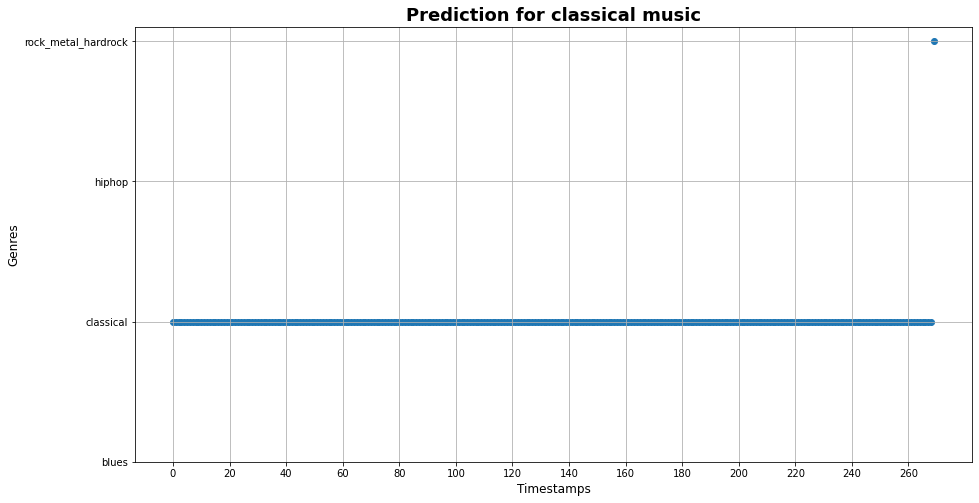

In [ ]:
x = range(len(classic_preds))

plt.figure(figsize=(15, 8))
plt.scatter(x,  classic_preds)
plt.xlabel("Timestamps", fontsize=12)
plt.ylabel("Genres", fontsize=12)
plt.title("Prediction for classical music", fontsize=18, fontweight="bold")
plt.yticks([0,1,2,3],['blues','classical','hiphop','rock_metal_hardrock'])
plt.xticks(np.arange(min(x), max(x)+1, 20))
plt.grid(True)
plt.show()


Το μοντέλο κάνει σωστή πρόβλεψη για τη κλασσική μουσική, ενώ βγάζει νόημα η πρόβλεψη ενώς είδους μουσικής σε σχέση με τον ήχο του βίντεο.

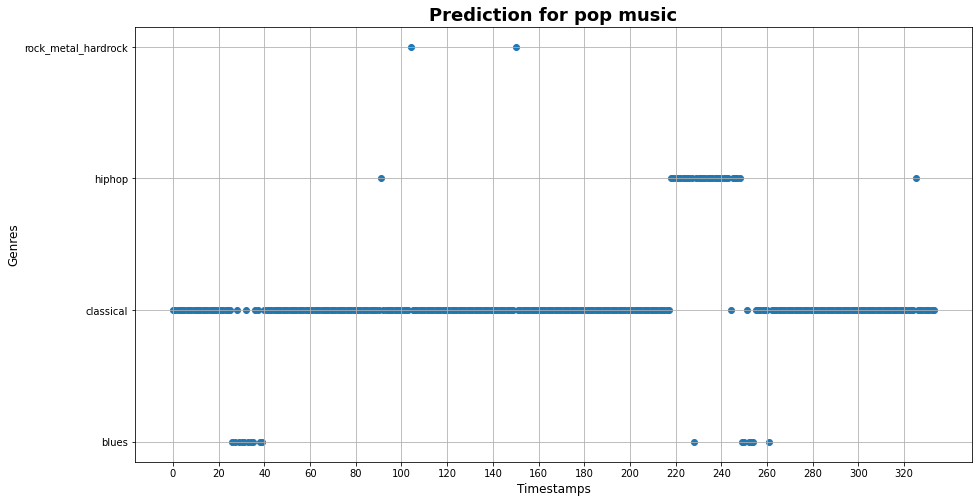

In [ ]:
x = range(len(pop_preds))
plt.figure(figsize=(15, 8))
plt.scatter(x, pop_preds)
plt.xlabel("Timestamps", fontsize=12)
plt.ylabel("Genres", fontsize=12)
plt.title("Prediction for pop music", fontsize=18, fontweight="bold")
plt.yticks([0,1,2,3],['blues','classical','hiphop','rock_metal_hardrock'])
plt.xticks(np.arange(min(x), max(x)+1, 20))
plt.grid(True)
plt.show()


Οι προλβλέψεις μουσική βγάζουν νόημα σε σχέση με τον ήχο του βίντεο καθώς παρατηρούμε ότι στα timestamps που αλλάζουν οι προβλέψεις του μοντέλου αλλάζει και το ύφος της μουσικής.Παρ΄όλα αυτά ρο μεγαλύτερο κομμάτι του τραγουδιού προβλέπεται ως κλασσική μουσικη.

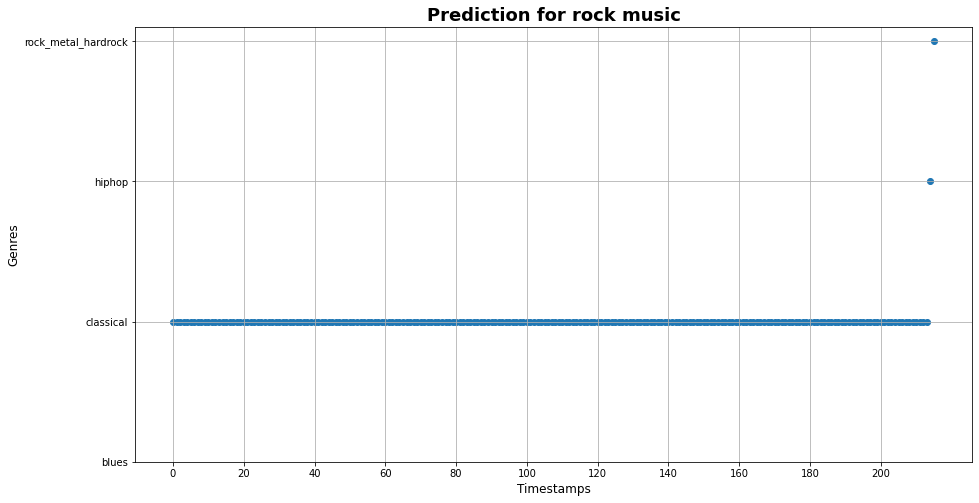

In [ ]:
x = range(len(rock_preds))

plt.figure(figsize=(15, 8))
plt.scatter(x, rock_preds)
plt.xlabel("Timestamps", fontsize=12)
plt.ylabel("Genres", fontsize=12)
plt.title("Prediction for rock music", fontsize=18, fontweight="bold")
plt.yticks([0,1,2,3],['blues','classical','hiphop','rock_metal_hardrock'])
plt.xticks(np.arange(min(x), max(x)+1, 20))
plt.grid(True)
plt.show()


Το μοντέλο προβλέπει το σύνολο του κομματατιού ως κλασσική μουσική παρά το γεγονός ότι είναι ροκ.Ενώ με βάση τον ήχο του βίντεο είναι λογικό να προβλέπεται όλο το κομμάτι ως ένα είδος μουσικής.

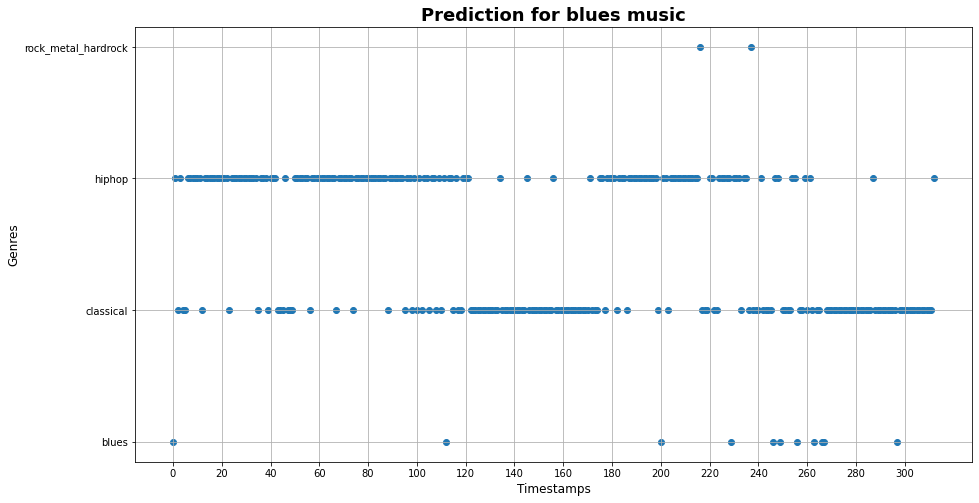

In [ ]:
x = range(len(blues_preds))
plt.figure(figsize=(15, 8))

plt.scatter(x, blues_preds)
plt.xlabel("Timestamps", fontsize=12)
plt.ylabel("Genres", fontsize=12)
plt.title("Prediction for blues music", fontsize=18, fontweight="bold")
plt.yticks([0,1,2,3],['blues','classical','hiphop','rock_metal_hardrock'])
plt.xticks(np.arange(min(x), max(x)+1, 20))
plt.grid(True)
plt.show()



Οι διαφορετικές προβλέψεις βγάζουν νόημα σε σχέση με τον ήχο του βίντεο όμως δεν προβλέπεται μπλουζ όπως θα έπρεπε αλλά κλασσική μουσική και χιπχοπ.

Συμπερασματικά, η απόδοση του μοντελού στα βίντεο μειώνεται σε σχέση με την απόδοση στο test set.Επίσης φαίνεται ότι το μοντέλο είναι bias στο να προβλέπει κλασσική μουσική σε σχέση με τα άλλα είδη.